# Equação de Poisson em 2D, via FFT

Pretendemos resolver o problema em 2D:  

$$ \nabla^2\phi(x,y)=f(x,y)\;\;\;(x,y)\in[0, L_x]\times[0, L_y] $$ 

sujeita a condições fronteira periódicas:

$$ \phi(x,0)=\phi(x,L_y) \;\;\; x\in[0, L_x] $$
$$ \phi(0,y)=\phi(L_x,y) \;\;\; y\in[0, L_y] $$
$$  \frac{\partial \phi}{\partial x}(0, y) = \frac{\partial \phi}{\partial x}(L_x, y)\;\;\; y\in[0, L_y] $$
$$ \frac{\partial \phi}{\partial y}(x, 0) = \frac{\partial \phi}{\partial y}(x, L_y)\;\;\; x\in[0, L_x]  $$

## Abordagem via FFT

Vamos expandir $\phi(x,y) $ em série de Fourier:  
$$ \phi(x,y)=\sum_{p,q=-\infty}^{\infty}\hat{\phi}_{pq}e^{-i2\pi p\frac{x}{L_x}}e^{-i2\pi q\frac{y}{L_y}} $$
onde os $ \hat{\phi}_{pq} $ são os coeficientes da expansão. Vamos fazer o mesmo para  $f(x,y)$, com os coeficientes da expansão  $\hat{f}_{pq}$. Substituindo as expansões em série na equação de Poisson, temos:  
$$ \left[\left(-i2\pi \frac{p}{L_x}\right)^2+\left(-i2\pi \frac{q}{L_y}\right)^2\right]\hat{\phi}_{pq}=\hat{f}_{pq} $$

Resolver a equação de Poisson reduz-se entãom a determinar os coeficientes $ \hat{\phi}_{pq} $ .

Calculando a série de Fourier de $\phi(x,y) $ nos pontos $(x_m,y_n)=(m\Delta x,n\Delta y),$ com $m=0,1,\ldots,M$ e $n=0,1,\ldots,N$, temos:

$$ \phi_{mn}=\phi(m\Delta x,n\Delta y)=\sum_{p,q=-\infty}^{\infty}\hat{\phi}_{pq}e^{-i2\pi p\frac{m\Delta x}{L_x}}e^{-i2\pi q\frac{n\Delta y}{L_y}}. $$

Finalmente escolhemos
$$ \Delta x = \frac{L_x}{M}$$ e $$ \Delta y = \frac{L_y}{N}$$ e se truncarmos a série de Fourier a $ (M+1)\times (N+1)$ termos, virá:

$$ \phi_{mn}=\sum_{p=0}^{M}\sum_{q=0}^{N}\hat{\phi}_{pq}e^{-i2\pi p\frac{m\Delta x}{L_x}}e^{-i2\pi q\frac{n\Delta y}{L_y}} $$
que tem a forma de uma **DFT** (transformada de Fourier Discreta). O mesmo se passa com $f(x,y)$, ié., 
$$ f_{mn}=\sum_{p=0}^{M}\sum_{q=0}^{N}\hat{f}_{pq}e^{-i2\pi p\frac{m\Delta x}{L_x}}e^{-i2\pi q\frac{n\Delta y}{L_y}} ,$$ em que  $f_{mn}=f(m \Delta x, n\Delta y) .$  

A abordagem é então a seguinte:

1. amostrar a função $f(x,y)$ nos pontos $(m \Delta x, n\Delta y)$;
2. calcular a DFT de $ f_{mn}$;
3. dividir $ \hat{f}_{pq}$ por $ \left[\left(-i2\pi \frac{p}{L_x}\right)^2+\left(-i2\pi \frac{q}{L_y}\right)^2\right] $ para obter $ \hat{\phi}_{pq}$;
4. calcular a IDFT de $ \hat{\phi}_{pq}$

### Problema

A equação acima pode ser resolvida para qualquer $(p,q)$ excepto $p=q=0$, o que leva a uma ambiguidade na determinação do coeficiente à frequência zero $ \hat{\phi}_{00}$.

### Solução

Duma perspectiva diferente, as condições fronteira definem a solução da equação de Poisson a menos de uma constante aditiva: se $\phi(x,y) $ obedece à equação e obedece às condições fronteira periódicas, então também $\phi(x,y) + c \ $ o faz, para qualquer constante real $c$. Então precisamos de uma condição adicional para fixar $c$. A escolha habitual é que:
$$ \int^{L_x}_0 \int^{L_y}_0 \phi(x,y) dx\;dy =0 .$$


Note que, ao usar condições fronteira periódicas e integrar a equação de Poisson, pode -se mostrar facilmente que o termo fonte $f(x,y)$ também deve obedecer à condição:
$$ \int^{L_x}_0 \int^{L_y}_0 f(x,y) dx\;dy =0 $$



In [1]:
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft,fft2,ifft2,ifft,irfft2,rfft2
import random as random
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [7]:
# Definimos uma função para a tranformada seno discreta (DST) à custa da fft, simetrizando a função f
def dst(x,axis=-1):
    """Discrete Sine Transform (DST-I)

    Implemented using 2(N+1)-point FFT
    xsym = r_[0,x,0,-x[::-1]]
    DST = (-imag(fft(xsym))/2)[1:(N+1)]

    adjusted to work over an arbitrary axis for entire n-dim array
    """
    n    = len(x.shape)
    N    = x.shape[axis]
    slices = [None]*3
    for k in range(3):
        slices[k] = []
        for j in range(n):
            slices[k].append(slice(None))
    newshape = list(x.shape)
    newshape[axis] = 2*(N+1)
    xsym = np.zeros(newshape,float)
    slices[0][axis] = slice(1,N+1)
    slices[1][axis] = slice(N+2,None)
    slices[2][axis] = slice(None,None,-1)
    for k in range(3):
        slices[k] = tuple(slices[k])
    xsym[slices[0]] = x
    xsym[slices[1]] = -x[slices[2]]
    DST = fft(xsym,axis=axis)
    #print xtilde
    return (-(DST.imag)/2)[slices[0]]


In [8]:
# Definimos a DST 2D; a IDST  é igual à DST por causa da simetria

def dst2(x,axes=(-1,-2)):
    return dst(dst(x,axis=axes[0]),axis=axes[1])  # primeiro numa direção, depois na na segunda direção (transversal)

def idst2(x,axes=(-1,-2)):
    return dst(dst(x,axis=axes[0]),axis=axes[1])

In [9]:
# Agora definimos um "solver" da eq. Poisson em 2D, num domínio quadrado, usando o algoritmo
# descrito acima. Este método pode ser generalizado a um domínio rectangular.

def fft_poisson(f,h):

    m,n   = f.shape
    f_hat = np.zeros([m,n])
    u_hat = f_hat              # fazer do mesmo formato
    u     = u_hat

    f_hat = idst2(f)           # f_bar= transformada fourier de f

    f_hat = f_hat * (2/n+1)**2  # Normalizar
    #u_bar = np.zeros([n,n])
    lam   = np.arange(1,n+1)
    lam   = -4/h**2 * (np.sin((lam*np.pi) / (2*(n + 1))))**2   #  $calcular $\lambda_x$
    #para um domínio rectangular, adicionar $lambda_y$
    for i in range(0,n):
        for j in range(0,n):
            u_hat[i,j] = (f_hat[i,j]) / (lam[i] + lam[j])

    u   = dst2(u_hat)                    # transformada seno inversa
    u   = u * (2/(n+1))**2               # normalizar; alterar se domínio rectangular
    return u

In [12]:
# Definimos os parâmetros, e domínio do problema, etc

# definir limites a,b,parâmetros
a    = 0; b = 1;
alpha = 10                # alpha define número de pontos da grelha, n = 2^alpha
n    = 2**alpha
L    = b-a              # comprimento do sistema, L_x = L_y

xe   = np.linspace(a,b,n); 
ye   = np.linspace(a,b,n);
x, y = np.meshgrid(xe,ye)



h    = L/(n);           # tamanho do passo espacial 
h2   = h**2;            # passo ao quadrado
hx2  = h2;              # começamos com um quadrado,hx2=hy2
hy2  = h2;
f    = np.zeros([n,n]); # alocamos espaço para a fonte

# Colocamos cargas no domínio.


# condições iniciais  (seleccionar, ou mudar!)

#f[int(n/2):n,int(n/2):n] = 1; # condição inicial
print(int((n+1)/2))
f[int((n+1)/2),int((n+1)/2-10)] = 20   # positiva ao centro
f[int((n+1)/2),int((n+1)/2+10)] = -20  # negativa ao centro
#f[random.randint(0,n),random.randint(0,n)] = -10    # colocar aleatoriamente carga (negativa)


nx,ny = np.array(f.shape)-1       #último índice 
U     = np.zeros([n,n])

# impôr condições fronteira
# CONDIÇÕES FRONTEIRA
# fazer U(x,y) = g(x,y)
U[0,:]  = 0
U[nx,:] = 0   # 5e-5
U[:,0]  = 0
U[:,ny] = 0

# homogenizar as  condições fronteira

f[1,:] = f[1,:] + U[0,:]/hx2;     # @ x=dx
f[nx-1,:] = f[nx-1,:] + U[n-1,:]/hx2;   # @ x = L_x -dx

f[:,1] = f[:,1] + U[:,0]/hy2;     # @ y = dy
f[:,ny-1] = f[:,ny-1] + U[:,n-1]/hy2;  # @ y = L_y - dy

512


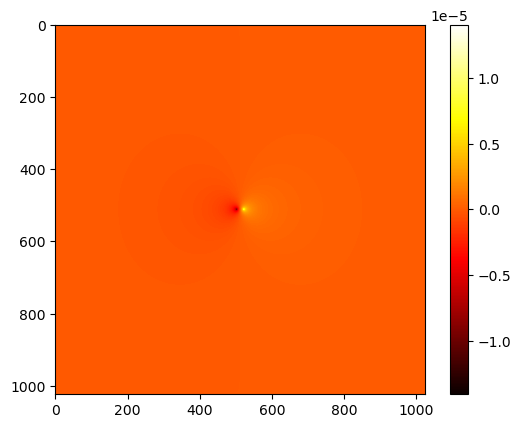

In [13]:
# resolver a equação:

U = fft_poisson(f,h)

# plot
plt.figure()
# escolher um  tipo de plot
plt.imshow((U),cmap='hot')  # imagem com nível de cores (cmap)
plt.colorbar()
#plt.contour(U,50)         # contornos de nível
#plt.contour(f)           # plot sobreposta a função fonte

plt.show()

#display(gcf())